# Analisi della social network tra istituti di ricerca e università.
L'obiettivo di questa analisi è quella di individuare se, all'interno della comunità scientifica, esistano
dei gruppi naturali (comunità) tra i diversi istituti di ricerca nel campo della Energia.

In [9]:
# Importiamo tutte le dipendenze

from importlib import reload
from datetime import datetime
from pathlib import Path
from tqdm.notebook import tqdm
from utils.graphing import FigSize, GLAYOUTS
import utils.graphing as graphing
import utils.metrics as metrics
import networkx as nx
import os
import pandas as pd
import utils.preproc as preproc
import warnings
import ipdb


CITATIONS_DIRECTED_GRAPH = "./data/cit-HepTh.txt"
CITATIONS_ABSTRACTS_DIR = "./data/cit-HepTh-abstracts"

ROR_DATA = "./data/ror-data.csv"
UNIVERSITIES_DATA = "./data/all_universities.csv"

warnings.filterwarnings("ignore")

Questa linea genera la session_id. Se la sovrascrivi si intende che hai fatto cambiamenti al dataset
perciò il resto del codice non farà più affidamento alla sessione precedente e quindi alcuni file
vanno rigenerati

Se invece vuoi usare una session precedente, usa il blocco sotto e definisci manualmente il numero di sessione


In [ ]:
s = datetime.now().strftime("%y%m%d%H%M")
session_id = f"{s}"  # NUOVA SESSIONE
SESSION_PATH = f"data/sessions/{session_id}"
os.makedirs(SESSION_PATH, exist_ok=True)

In [10]:
session_id = "2511212247"  # RICARICA UNA SESSIONE
SESSION_PATH = f"data/sessions/{session_id}"

# Preprocessamento
eseguiamo le operazioni preliminari di caricamento dei dati

citations contiene il grafo diretto con colonne target e source

In [ ]:
records = []

for abp in tqdm(Path(CITATIONS_ABSTRACTS_DIR).rglob("*")):
    if abp.is_file():
        with open(abp, "r", encoding="utf-8", errors="ignore") as f:
            abs = f.read()

        data = {"id": abp.stem}
        fields = preproc.extract_fields(abs)
        # preproc è una classe statica definita in utils.py

        if isinstance(fields, dict):
            data.update(fields)
            records.append(data)

papers = pd.DataFrame(records)
del records

Mapping dei paper alle rispettive università

In [ ]:
ror = pd.read_csv(ROR_DATA)
ror["clean_url"] = (
    ror["links"].str.replace(r"^https?://", "", regex=True).str.split("/").str[0]
)
ror["tld2"] = ror["clean_url"].str.extract(r"([a-zA-Z0-9-]+\.[a-zA-Z0-9-]+)$")

universities = pd.read_csv(UNIVERSITIES_DATA)

domain_mapping = {
    str(row.id): preproc.extract_domain(row.email, ror, universities)
    for row in tqdm(papers.itertuples())
}

In [ ]:
# leggi il file come edge-list: ignora righe che iniziano con '#' e usa whitespace come separatore

cit_hepth = pd.read_csv(
    CITATIONS_DIRECTED_GRAPH, comment="#", sep="\\s+", header=None, engine="python"
)

# Prendiamo le prime due colonne come source/target
citations = cit_hepth.iloc[:, :2].copy()
citations.columns = ["source", "target"]
citations["source"] = pd.to_numeric(citations["source"])
citations["target"] = pd.to_numeric(citations["target"])

del cit_hepth  # non ci serve più

citations_uni = citations.copy()
citations_country = citations.copy()


def safe_get_name(x):
    v = domain_mapping.get(x)
    if isinstance(v, dict):
        return v.get("name")
    return None


def safe_get_country(x):
    v = domain_mapping.get(x)
    if isinstance(v, dict):
        return v.get("country")
    return None


citations_uni["source"] = citations["source"].astype(str).map(safe_get_name)
citations_uni["target"] = citations["target"].astype(str).map(safe_get_name)

citations_country["source"] = citations["source"].astype(str).map(safe_get_country)
citations_country["target"] = citations["target"].astype(str).map(safe_get_country)

In [ ]:
citations_uni.dropna().sample(n=3)

In [ ]:
citations_country.dropna().sample(n=3)

# SALVATAGGIO o CARICAMENTO

## salvataggio

In [ ]:
citations_uni.to_csv(f"{SESSION_PATH}/citations-uni.csv", index=False)
citations_country.to_csv(f"{SESSION_PATH}/citations-country.csv", index=False)

In [ ]:
papers.to_csv(f"{SESSION_PATH}/papers.csv", index=False)

## caricamento

In [15]:
citations_uni = pd.read_csv(f"{SESSION_PATH}/citations-uni.csv")
citations_country = pd.read_csv(f"{SESSION_PATH}/citations-country.csv")

In [12]:
papers = pd.read_csv(f"{SESSION_PATH}/papers.csv")

# Grafi

In [30]:
# per testing e sviluppo delle librerie, rilanciare questo blocco ogni volta che viene
# aggiornata una libreria

# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0


graphing = reload(graphing)

## Circular Layout

In [ ]:
name = "circular-wpg"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.circular
pos = lay(wpg)
data = graphing.gen_graph_data(wpg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

## ARF Layout

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "graph-arf-wpg"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.arf
pos = lay(wpg)
data = graphing.gen_graph_data(wpg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "graph-bfs"

pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.bipartite
pos = lay(pg)
data = graphing.gen_default(pg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "graph-bfs"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.bfs
pos = lay(pg)
data = graphing.gen_default(pg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "kamada-wpg"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.kamada
pos = lay(wpg, weight="w")
data = graphing.gen_graph_data(wpg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "planar"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.planar
pos = lay(pg)
data = graphing.gen_default(pg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "spring-base-wpg"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.spring
pos = lay(wpg, weight="w")
data = graphing.gen_graph_data(wpg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "spring-force-wpg"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.spring
pos = lay(wpg, weight="w", method="force")
data = graphing.gen_graph_data(wpg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "spring-energy-wpg"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.spring
pos = lay(wpg, weight="w", method="energy")
data = graphing.gen_graph_data(wpg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}", show_labels=False)

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "spiral"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.spiral
pos = lay(pg, resolution=1)
data = graphing.gen_graph_data(pg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

In [ ]:
# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
from importlib import reload  # Python 3.4+
graphing = reload(graphing)
name = "spiral-equidistant"
pg = nx.DiGraph()
add_edges(pg, citations_uni)
wpg = edge_collapse(pg, nx.DiGraph)
lay = graphing.GLAYOUTS.spiral
pos = lay(pg, resolution=1, equidistant=True)
data = graphing.gen_graph_data(pg, pos)
graphing.plot_graph(data, save_path=f"{SESSION_PATH}/{name}")

Visualizzazione del grafo

In [10]:
unique = len(pd.unique(citations_uni[['source', 'target']].dropna().values.ravel('K')))
self_loops = len(citations_uni[citations_uni['source'] == citations_uni["target"]].dropna())
edges = len(citations_uni.dropna())
print(f"Abbiamo {unique} universita e centri di ricerca")
print(f"        {edges} archi")
print(f"        {self_loops} self loops")

Abbiamo 560 universita e centri di ricerca
        153881 archi
        21490 self loops


In [11]:
unique = len(pd.unique(citations_country[['source', 'target']].dropna().values.ravel('K')))
self_loops = len(citations_country[citations_country['source'] == citations_country["target"]].dropna())
edges = len(citations_country.dropna())
print(f"Abbiamo {unique} stati")
print(f"        {edges} archi")
print(f"        {self_loops} self loops")

Abbiamo 63 stati
        153881 archi
        57976 self loops


In [ ]:
citations_uni.count()

## Metriche

Qua calcoliamo:
- closeness centrality
- degree centrality
- betweenness centrality
- eigenvector centrality

### Definizione funzioni

In [86]:
# per testing e sviluppo delle librerie, rilanciare questo blocco ogni volta che viene
# aggiornata una libreria

# Source - https://stackoverflow.com/a/437591
# Posted by cdleary, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0


metrics = reload(metrics)

### Calcolo Metriche

In [17]:
g = nx.DiGraph()
graphing.add_edges(g, citations_uni)
wg = g.copy()
wg = graphing.edge_collapse(g, nx.DiGraph)

In [ ]:
gm  = metrics.calc_metrics(g)
wgm = metrics.calc_metrics(wg)

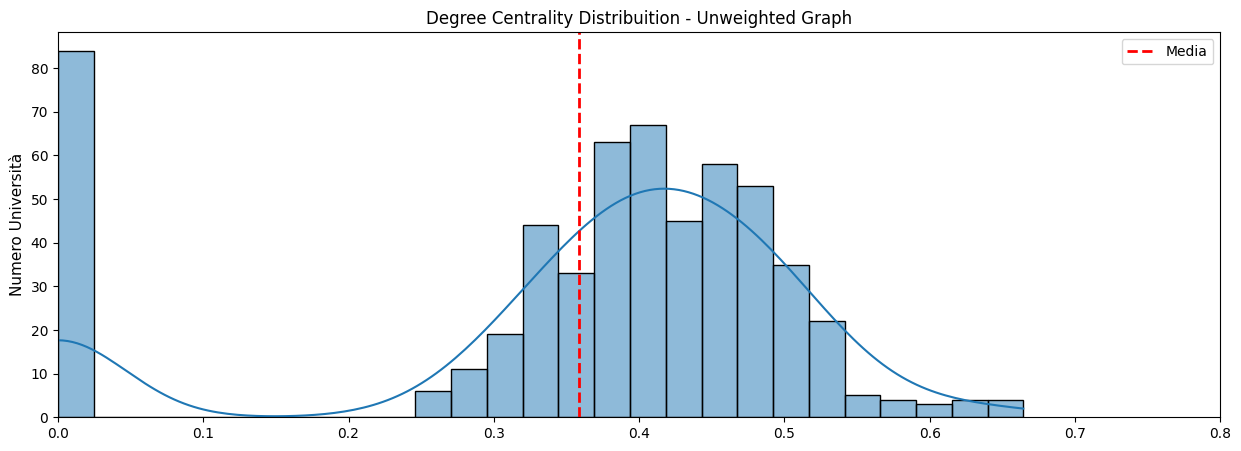

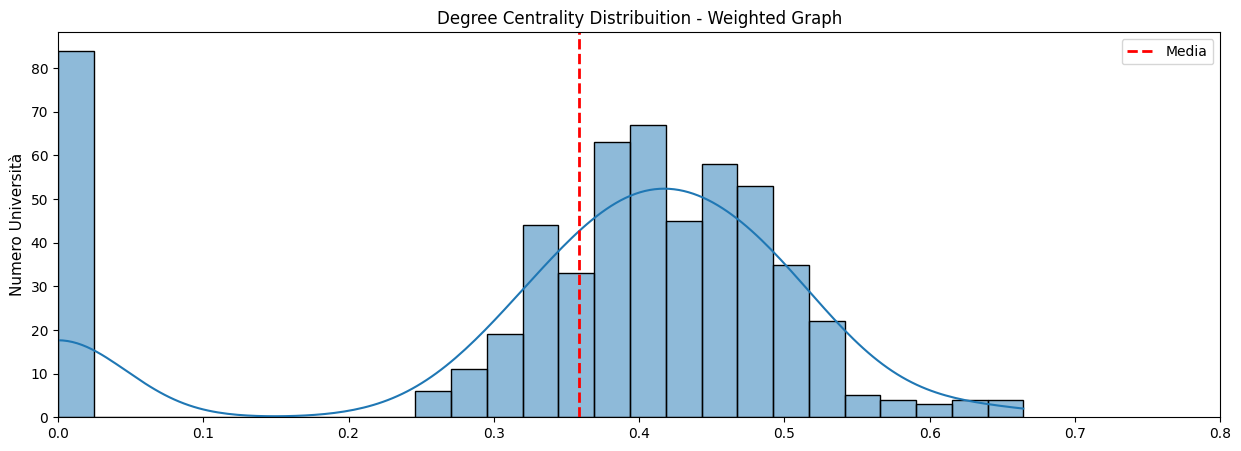

In [87]:
metrics.plot_distribution(list(gm[0].values()), SESSION_PATH, "Degree Centrality Distribuition - Unweighted Graph", 0.80)
metrics.plot_distribution(list(wgm[0].values()), SESSION_PATH, "Degree Centrality Distribuition - Weighted Graph", 0.80)

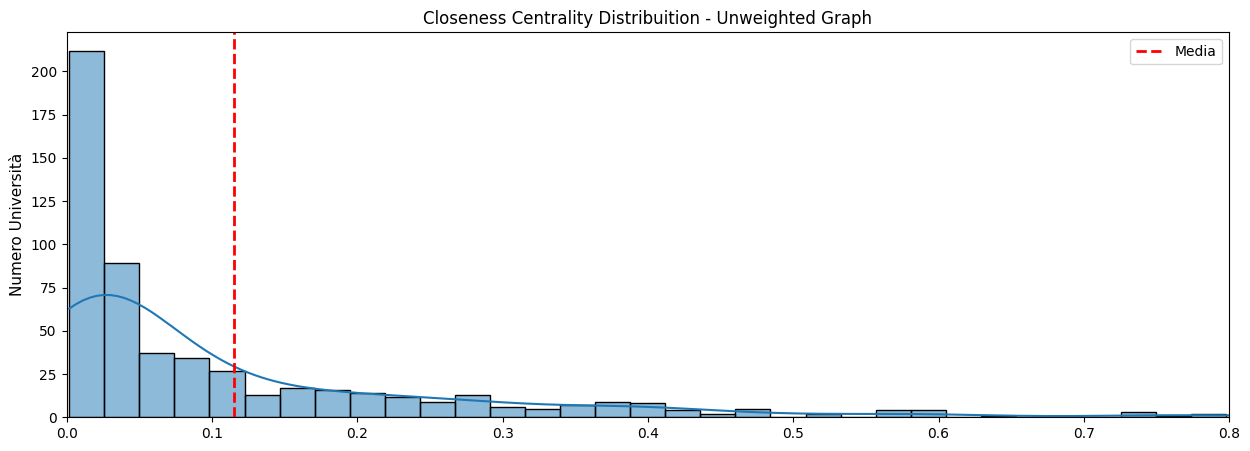

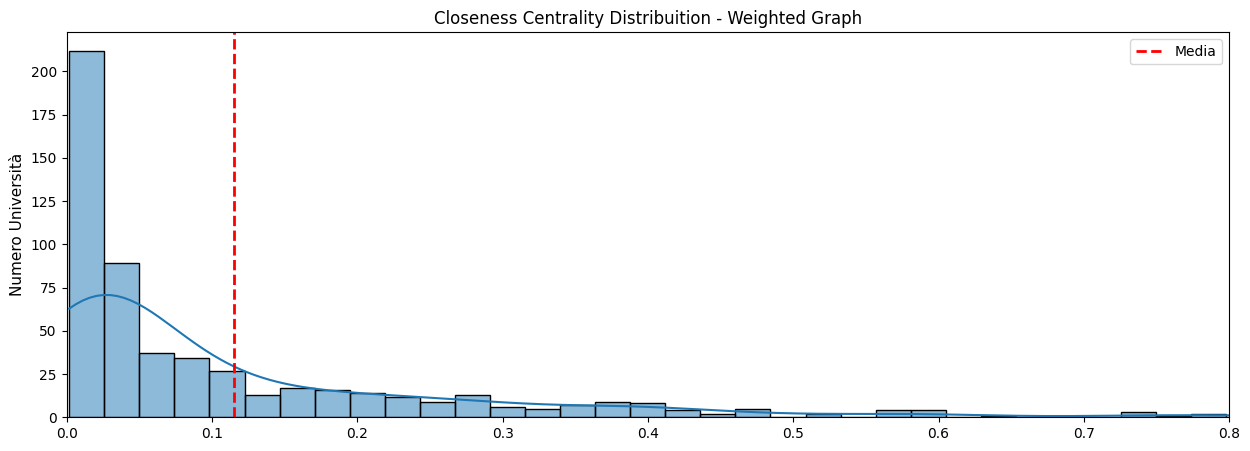

In [88]:
metrics.plot_distribution(list(gm[1].values()), SESSION_PATH, "Closeness Centrality Distribuition - Unweighted Graph", 0.80)
metrics.plot_distribution(list(wgm[1].values()), SESSION_PATH, "Closeness Centrality Distribuition - Weighted Graph", 0.80)

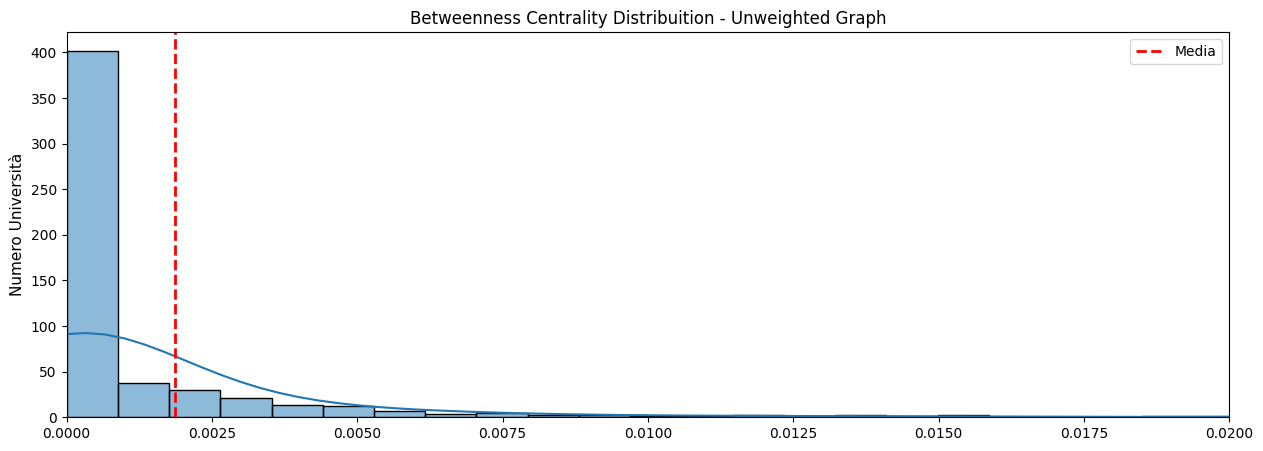

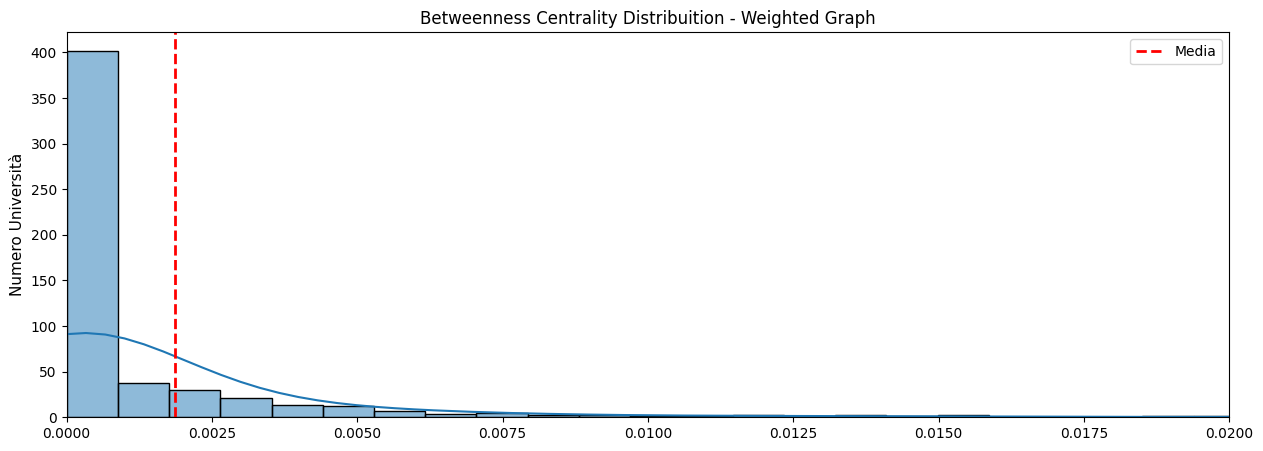

In [89]:
metrics.plot_distribution(list(gm[2].values()), SESSION_PATH, "Betweenness Centrality Distribuition - Unweighted Graph", 0.02)
metrics.plot_distribution(list(wgm[2].values()), SESSION_PATH, "Betweenness Centrality Distribuition - Weighted Graph", 0.02)

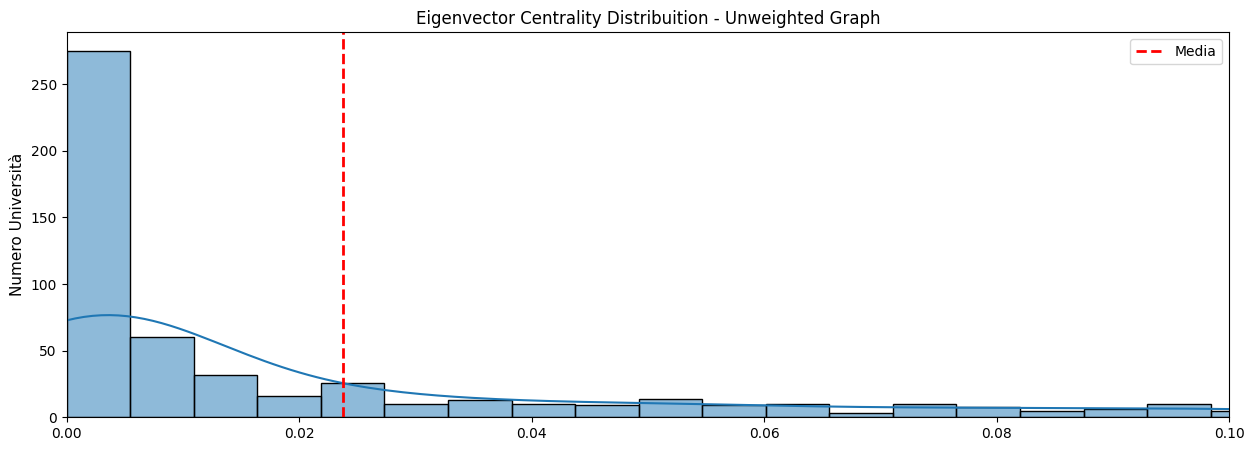

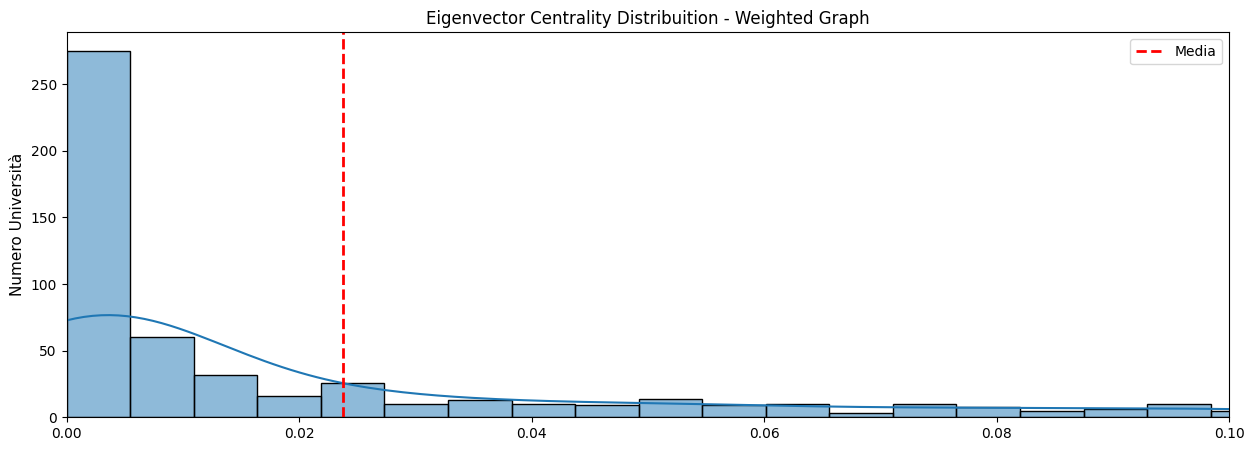

In [ ]:
metrics.plot_distribution(list(gm[3].values()), SESSION_PATH, "Eigenvector Centrality Distribuition - Unweighted Graph", 0.1)
metrics.plot_distribution(list(wgm[3].values()), SESSION_PATH, "Eigenvector Centrality Distribuition - Weighted Graph", 0.1)
# End of life